<a href="https://colab.research.google.com/github/ricoprediansyah/CV-FASTER_RCNN-MASKER-CINA/blob/main/FASTER_RCNN_MASKER_CHINA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. Faster R-CNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book-en/blob/master/book/chapters/en/object-detection/Ch5-Faster-R-CNN.ipynb)

In chapter 4, we built a medical mask detection model using RetinaNet, a one-stage detector model. In this chapter, we will detect medical masks with Faster R-CNN, a two-stage detector.

From chapters 5.1 to 5.3, we will load the data, divide it into training and test data, and define the dataset class based on the code introduced in chapters 2 and 3. In chapter 5.4, we will use the torchvision API to load the pretrained model. In chapter 5.5, we will train the model through transfer learning, and finally, we will make inferences based on the test dataset and evaluate the model's performance in chapter 5.6.

Before we begin the experiment, we should note that Google Colab allocates random GPUs, so a memory shortage may occur depending on the GPU that has been allotted.

It is recommended that you confirm that the GPU has enough memory before beginning the experiment. If you reset the runtime, you can be assigned a new GPU.

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 5.1 Loading the Data


We will load the data using the code from chapter 2.1. The code below describes the procedure for downloading and extracting the FaceMaskDetection dataset using the PL_data_loader.py file in Tutorial-Book-Utils repo, which is on PseudoLab's Github.

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.62 KiB | 11.62 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=c0fa132d-4413-4967-8921-bc7bbad73071
To: /content/Face Mask Detection.zip
100% 417M/417M [00:09<00:00, 46.0MB/s]
Face Mask Detection.zip download complete!


## 5.2 Data Separation


We will separate the dataset as in chapter 3.3. By using the code below, 170 images are extracted randomly and moved to the test folder.

In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


We will also load the packages needed for modeling. `torchvision` is used for image processing and has built-in packages for datasets and models.

In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

## Defining the Dataset Class

This time, we will define the functions for the bounding boxes as shown in chapter 2.3.

In [ ]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 2 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

Next, as in chapter 4.3, we will define the dataset class and data loader. The dataset will be loaded and the batch size set to 4 through the `torch.utils.data.DataLoader{/code0} function. You can change the batch size according to your individual memory size.

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

## 5.4 Import Model

`torchvision.models.detection` provides the Faster R-CNN API (`torchvision.models.detection.fasterrcnn_resnet50_fpn`) so it can be easily implemented. This provides a model that has been pre-trained with the COCO dataset using ResNet50. We can choose to load the pre-trained weights by declaring `pretrained=True/False`.

When loading the model, set the desired number of classes in `num_classes` and use the model. One thing to note when using Faster R-CNN is that you should include the background class when specifying the class number in `num_classes`. In other words, you need to increase the number of classes in the dataset by one in order to add the background class.

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 5.5 Transfer Learning


We will now perform transfer learning on the Face Mask Detection dataset. The Face Mask Detection dataset consists of 3 classes, so we will load the model by setting `num_classes` to 4, making sure to include the background class.

If the current environment allows it, send the model to the GPU memory in order to speed up training.

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 192MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

You can see what layers Faster R-CNN is composed of through the above output. Also, the availability of the GPU can be seen through `torch.cuda.is_available()`.

In [ ]:
torch.cuda.is_available()

True

Now that the model has been initiated, we will train it. The parameter for setting the number of epochs for training is (`num_epochs`) and will be set to 10. We will optimize the model using the SGD method. Each hyper parameter can be modified for the user's needs.

In [ ]:
num_epochs = 2
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

Now we will train the model. Using the data_loader created above, we will input the data into the model in batches. Then, we will calculate the loss and optimize the model weights. By observing the loss printed at every epoch, we can see that the training process is being executed.

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 46.28260803222656, time : 265.39952635765076
epoch : 2, Loss : 38.096866607666016, time : 266.0771977901459


If we want to save the trained weights, we can use `torch.save` to save and use the code underneath it to load it when needed.

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<ipython-input-15-3f9f79dbc0de>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))


<All keys matched successfully>

## 5.6 Inference


Since the model has been trained, we will check the inference results to see if it has been trained well. The prediction results include the bounding box coordinates (boxes), classes (labels), and confidence scores (scores). Under the confidence scores (scores), the confidence value of the corresponding class is stored. We will define the function `make_prediction` to extract only those with a threshold of 0.5 or higher. Then we will print the results of the first batch of the test_data_loader.

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[211.7349,  60.3965, 254.9913,  98.5791],
        [117.2327,   3.0500, 133.2832,  17.7719]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9319, 0.8882], device='cuda:0')}, {'boxes': tensor([[218.7305,  99.6584, 258.0387, 138.2865],
        [129.2988, 109.3159, 179.3263, 152.9139],
        [ 40.9777, 109.4100,  67.6775, 140.1263],
        [303.0962, 131.1994, 330.7630, 158.4778],
        [ 82.1882,  83.7718,  95.1236, 111.7217],
        [ 29.0925,  89.6640,  45.0013, 104.7096],
        [165.5354,  91.4228, 178.8853, 108.4375],
        [  1.3650, 105.0975,  20.7335, 127.3044],
        [ 83.2140,  84.5134,  95.2042,  97.2438],
        [  1.7427, 104.0290,  20.9580, 127.4932]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.9818, 0.9543, 0.9366, 0.8482, 0.8414, 0.7860, 0.7016, 0.5901,
        0.5692], device='cuda:0')}]


Using the predicted result, we will draw the bounding boxes on the images. The image is plotted using the `plot_image_from_output` function defined above. Target is the actual position of the bounding boxes and Prediction is the predicted result from the model. We can see that the model has located the actual position of the bounding boxes well.

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


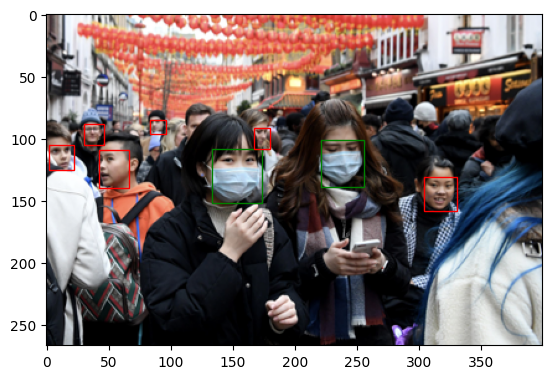

Prediction :  tensor([2, 2, 1, 1, 2, 1, 1, 2, 1, 1], device='cuda:0')


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

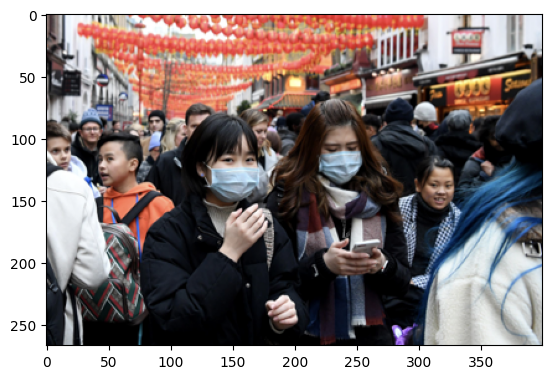

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

This time, we will evaluate the inference results for all of the test data. First, the predicted results and actual labels for all test data will be saved in `preds_adj_all` and `annot_all`, respectively.

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 85/85 [00:25<00:00,  3.34it/s]


Then, we will use the utils_ObjectDetection.py file in the Tutorial-Book-Utils folder to calculate the mAP value. the `get_batch_statistics` function is utilized to calculate several statistics using only bounding boxes with an IoU (Intersection over Union) value higher than 0.5. After that, the `ap_per_class` function is used to calculate the AP value for each class.

In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5546838068575397
AP : tensor([0.6948, 0.9692, 0.0000], dtype=torch.float64)


AP values are shown only for the 3 actual classes, excluding the background class. Even after training only 10 epochs, you can observe that it is better than the RetinaNet results from chapter 4. The model has a notable AP value of 0.9189 when detecting objects wearing a mask, which is annotated with class 1. It also shows an AP of 0.3664 for class 2, which represents objects that are not properly wearing a mask. It is well known that RetinaNet shows high performance despite being a one-stage method with FPN and focal loss, but it seems it is not suitable for this particular dataset. It may be also due to the lack of hyperparameter tuning.

This concludes the medical mask detection tutorial. Throughout this tutorial, we went from preprocessing the dataset to training and predicting the model. To achieve better results, you can increase the number of epochs for training or try hyperparameter tuning. Try applying the object detection model on the data you want and evaluate the results.